In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import bettermoments as bm
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

import numpy as np
from matplotlib.offsetbox import AnchoredOffsetbox, AuxTransformBox
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import astropy.units as u
from astropy.wcs.utils import proj_plane_pixel_scales
import cmcrameri.cm as cmc

#from astropy.visualization import wcsaxes

In [2]:
CORNERS = {
    "top right": 1,
    "top left": 2,
    "bottom left": 3,
    "bottom right": 4,
    "right": 5,
    "left": 6,
    "bottom": 8,
    "top": 9,
}

def add_beam(
    ax,
    header=None,
    major=None,
    minor=None,
    angle=None,
    corner="bottom left",
    frame=False,
    borderpad=0.4,
    pad=0.5,
    **kwargs,
):
    """
    Display the beam shape and size.

    Parameters
    ----------
    ax : :class:`~astropy.visualization.wcsaxes.WCSAxes`
        WCSAxes instance in which the beam shape and size is displayed. The WCS
        must be celestial.
    header : :class:`~astropy.io.fits.Header`, optional
        Header containing the beam parameters. If specified, the ``BMAJ``,
        ``BMIN``, and ``BPA`` keywords will be searched in the FITS header
        to set the major and minor axes and the position angle on the sky.
    major : float or :class:`~astropy.units.Quantity`, optional
        Major axis of the beam in degrees or an angular quantity.
    minor : float, or :class:`~astropy.units.Quantity`, optional
        Minor axis of the beam in degrees or an angular quantity.
    angle : float or :class:`~astropy.units.Quantity`, optional
        Position angle of the beam on the sky in degrees or an angular
        quantity in the anticlockwise direction.
    corner : str, optional
        The beam location. Acceptable values are ``'left'``, ``'right'``,
        ``'top'``, 'bottom', ``'top left'``, ``'top right'``, ``'bottom left'``
        (default), and ``'bottom right'``.
    frame : bool, optional
        Whether to display a frame behind the beam (default is ``False``).
    borderpad : float, optional
        Border padding, in fraction of the font size. Default is 0.4.
    pad : float, optional
        Padding around the beam, in fraction of the font size. Default is 0.5.
    kwargs
        Additional arguments are passed to :class:`matplotlib.patches.Ellipse`.

    Notes
    -----
    This function may be inaccurate when:

    - The pixel scales at the reference pixel are different from the pixel scales
      within the image extent (e.g., when the reference pixel is well outside of
      the image extent and the projection is non-linear)
    - The pixel scales in the two directions are very different from each other
      (e.g., rectangular pixels)

    """
    if header and major:
        raise ValueError(
            "Either header or major/minor/angle must be specified, not both."
        )

    if header:
        major = header["BMAJ"]
        minor = header["BMIN"]
        angle = header["BPA"]

    if isinstance(major, u.Quantity):
        major = major.to(u.degree).value

    if isinstance(minor, u.Quantity):
        minor = minor.to(u.degree).value

    if isinstance(angle, u.Quantity):
        angle = angle.to(u.degree).value


    pix_scale = proj_plane_pixel_scales(ax.wcs)
    sx = pix_scale[0]
    sy = pix_scale[1]
    degrees_per_pixel = np.sqrt(sx * sy)
    #else:
        #raise ValueError("Cannot show beam when WCS is not celestial")

    minor /= degrees_per_pixel
    major /= degrees_per_pixel

    aux_tr_box = AuxTransformBox(ax.transData)
    ellipse = Ellipse((0, 0), width=minor, height=major, angle=angle, **kwargs)
    aux_tr_box.add_artist(ellipse)
    box = AnchoredOffsetbox(
        child=aux_tr_box,
        pad=pad,
        borderpad=borderpad,
        loc=CORNERS[corner],
        frameon=frame,
    )
    ax.add_artist(box)

In [55]:
plt.style.use('default')
plt.rcParams.update({'font.size': 10})

In [4]:
bunit_add = fits.open("inc_23warp_21_wpa179.5_hanning.fits", mode="update")
bunit_add["PRIMARY"].header["BUNIT"] = 'Jy'
bunit_add.flush()
bunit_add.close()

In [5]:
path = 'inc_23warp_21_wpa179.5_hanning.fits'
data, velax = bm.load_cube(path)
rms = bm.estimate_RMS(data=data, N=1)
m0 = bm.collapse_zeroth(velax=velax, data=data, rms=rms)
bm.save_to_FITS(moments=m0, method='zeroth', path=path)

In [6]:
path = 'inc_23.0warp_21.0_wpa179.5.fits'
data, velax = bm.load_cube(path)
rms = bm.estimate_RMS(data=data, N=1)
m0 = bm.collapse_zeroth(velax=velax, data=data, rms=rms)
bm.save_to_FITS(moments=m0, method='zeroth', path=path)

In [7]:
inc23nowarpm0 = fits.open('inc_23.0warp_0.0_wpa0.0_M0.fits')
inc23nowarpm0_data = inc23nowarpm0["PRIMARY"].data

inc23warpm0 = fits.open('inc_23.0warp_5.25_wpa179.5_M0.fits')
inc23warpm0_data = inc23warpm0["PRIMARY"].data

In [8]:
warpext = fits.open('inc_23.0warp_21.0_wpa179.5_M0.fits')
warpext_data = warpext["PRIMARY"].data

In [9]:
512*0.05

25.6

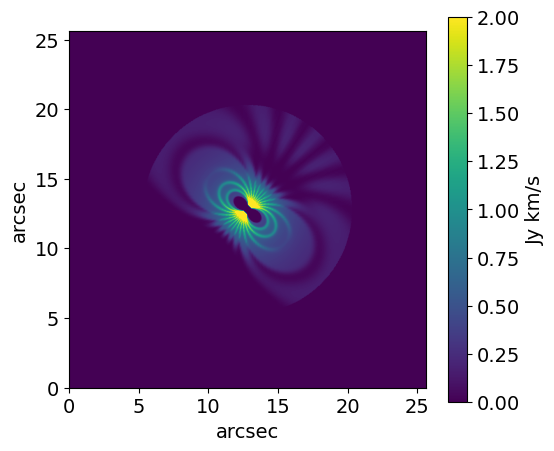

In [10]:
fig, ax = plt.subplots()
plt.imshow(inc23nowarpm0_data, vmin=0, vmax=2, extent=[0,25.6,0,25.6])
plt.colorbar(label="Jy km/s")
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
fig.set_size_inches(5.75, 5)
plt.savefig("m0nowarp.png")
#plt.xlabel()

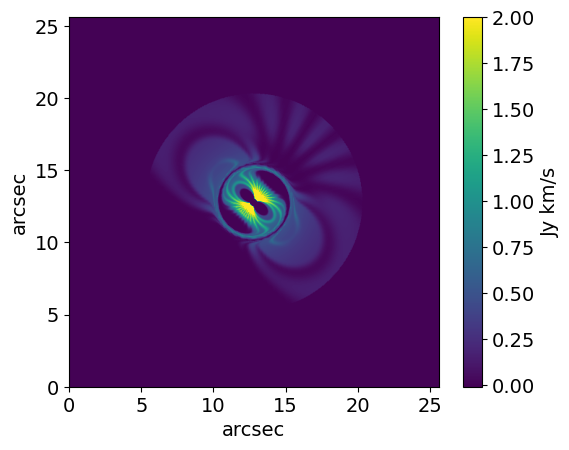

In [11]:
fig, ax = plt.subplots()
plt.imshow(inc23warpm0_data, vmin=-.01, vmax=2, extent=[0,25.6,0,25.6])
plt.colorbar(label="Jy km/s")
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
plt.savefig("m0warp.png")
#plt.xlabel()

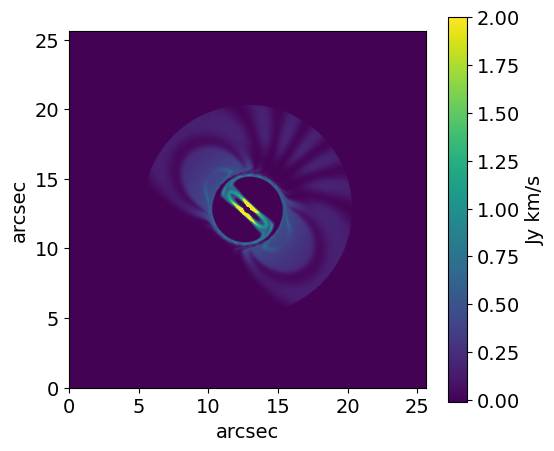

In [12]:
fig, ax = plt.subplots()
plt.imshow(warpext_data, vmin=-.01, vmax=2, extent=[0,25.6,0,25.6])
plt.colorbar(label="Jy km/s")
fig.set_size_inches(5.75, 5)
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
plt.savefig("m0warp.png")
#plt.xlabel()

In [13]:
path = '12CO_LSRK_cleanimage.fits'
data, velax = bm.load_cube(path)
rms = bm.estimate_RMS(data=data, N=1)
m0 = bm.collapse_zeroth(velax=velax, data=data, rms=rms)
bm.save_to_FITS(moments=m0, method='zeroth', path=path)

In [14]:
datam0 = fits.open('12CO_LSRK_cleanimage_M0.fits')
datam0_data = datam0[0].data
datam0_header = datam0[0].header

In [15]:
wcs_ceti = WCS(datam0_header)

In [16]:
wcs_ceti

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 23.65808076667  -15.676379615  
CRPIX : 513.0  513.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -4.444444444444e-06  4.444444444444e-06  
NAXIS : 1024  1024

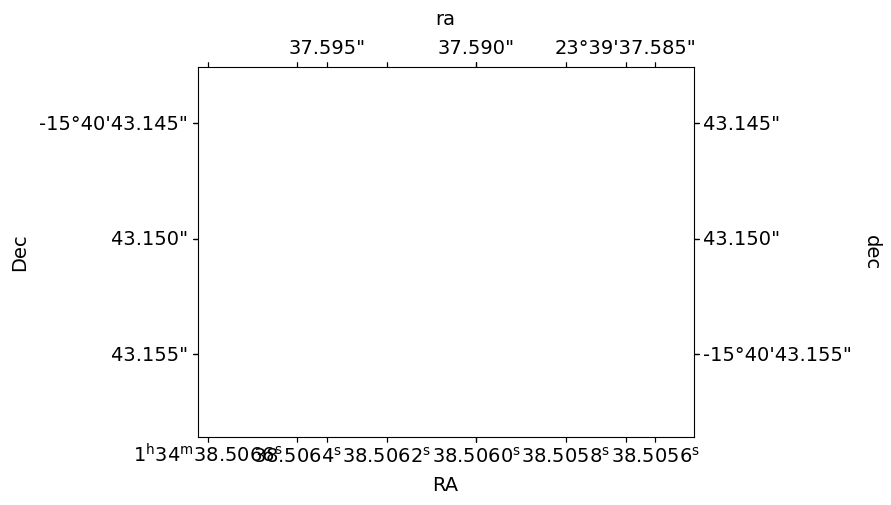

In [17]:
fig, ax = plt.subplots()
plt.imshow(datam0_data, origin="lower", cmap="cividis", aspect="equal")
#plt.imshow( , vmin=0, vmax=170)
ax = plt.subplot(projection=wcs_ceti)
overlay = ax.get_coords_overlay("icrs")
plt.xlabel(r"RA")
plt.ylabel(r"Dec")
#plt.colorbar(label="Jy m/s")
#fig.set_size_inches(5.75, 5)
#ax.set_ylim(300,700)
#ax.set_xlim(300,700)
#ax.set_xlabel("arcsec")
#ax.set_ylabel("arcsec")
#plt.savefig("m0warp.png")

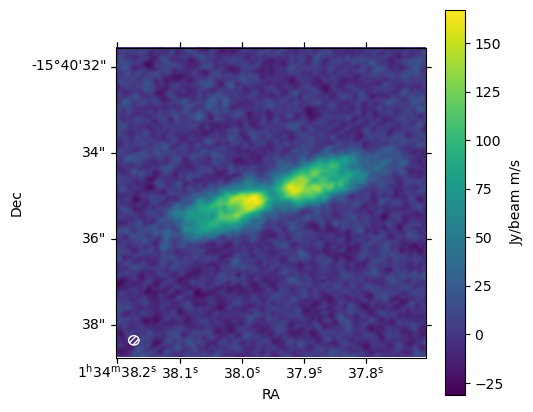

In [56]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wcs_ceti))
plt.imshow(datam0_data, origin='lower')
ax.set_ylim(275,725)
ax.set_xlim(275,725)
plt.colorbar(label='Jy/beam m/s')
plt.xlabel(r"RA")
plt.ylabel(r"Dec")
fig.set_size_inches(5, 5)
add_beam(ax, header=datam0_header, corner='bottom left', frame=False, fill=False,hatch='//////', color="white")

In [40]:
path = '12CO_LSRK_cleanimage.fits'
data, velax = bm.load_cube(path)
rms = bm.estimate_RMS(data=data, N=1)
threshold_mask = bm.get_threshold_mask(data=data,
                                       clip=4,
                                       smooth_threshold_mask=0.0)
masked_data = data*threshold_mask
m1 = bm.collapse_first(velax=velax, data=masked_data, rms=rms)
bm.save_to_FITS(moments=m1, method='first', path=path)

In [41]:
datam1 = fits.open('12CO_LSRK_cleanimage_M1.fits')
datam1_data = datam1[0].data
datam1_header = datam1[0].header

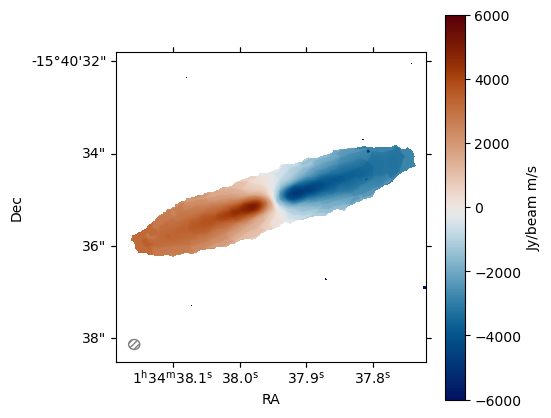

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wcs_ceti))
color_map = cmc.vik
plt.imshow(datam1_data-2780, origin='lower', cmap=color_map, vmin=-6000, vmax=6000)
ax.set_ylim(295,705)
ax.set_xlim(290,710)
plt.colorbar(label='Jy/beam m/s')
plt.xlabel(r"RA")
plt.ylabel(r"Dec")
fig.set_size_inches(5, 5)
add_beam(ax, header=datam0_header, corner='bottom left', frame=False, fill=False,hatch='//////', color="grey")

In [22]:
.16*800

128.0

In [23]:
datam0_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
BMAJ    = 6.74637738201353E-05                                                  
BMIN    = 6.02541863918304E-05                                                  
BPA     =    88.17740631103516                                                  
BUNIT   = 'Jy/beam m/s'                                                         
CTYPE1  = 'RA---SIN'                                                            
CRVAL1  =       23.65808076667                                                  
CDELT1  =  -4.444444444444E-06                                                  
CRPIX1  =                513

In [24]:
resid_m0 = fits.open('resid_m0_nosigma.fits')
resid_m0_data = resid_m0[0].data
resid_m0_header = resid_m0[0].header

In [25]:
wcs_resid = WCS(resid_m0_header)

In [26]:
wcs_resid

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  'STOKES'  
CRVAL : 23.65779056704  -15.67637259295  -4070.800096788  1.0  
CRPIX : 36.0  36.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -2.777777948778e-05  2.777777948778e-05  264.5953325818  1.0  
NAXIS : 70  70  1  1

In [27]:
resid_m0_header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                   70                                                  
NAXIS2  =                   70                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   1.675649722318E-04                                                  
BMIN    =   1.154586725963E-04                                                  
BPA     =   8.903882598877E+

In [28]:
# Plot beam
import math
xoff=3
yoff=3
t=np.arange(0.0,2.0*np.pi,0.05)
x=resid_m0_header['bmaj']*1800.0*np.cos(t)*np.cos((resid_m0_header['bpa']+90.0)*math.pi/180.0)-1800.0*resid_m0_header['bmin']*np.sin(t)*np.sin((resid_m0_header['bpa']+90.0)*math.pi/180.0)+xoff
y=1800.0*resid_m0_header['bmaj']*np.cos(t)*np.sin((resid_m0_header['bpa']+90.0)*math.pi/180.0)+1800.0*resid_m0_header['bmin']*np.sin(t)*np.cos((resid_m0_header['bpa']+90.0)*math.pi/180.0)+yoff

In [29]:
1/3600

0.0002777777777777778

AttributeError: 'SlicedFITSWCS' object has no attribute 'pixel_scale_matrix'

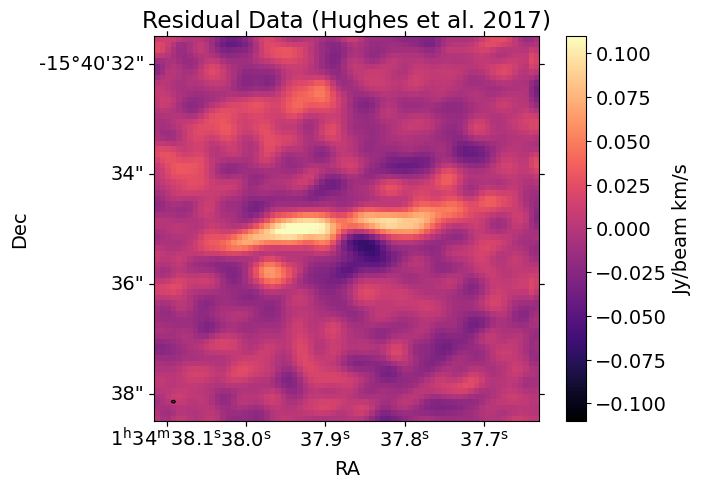

In [30]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wcs_resid[0,0,:,:]))
plt.imshow(resid_m0_data[0,0,:,:], origin='lower', cmap="magma", vmin=-0.11, vmax=0.11)
plt.colorbar(label='Jy/beam km/s')
plt.title("Residual Data (Hughes et al. 2017)")
plt.xlabel(r"RA")
plt.ylabel(r"Dec")
plt.fill(x,y,fill=False,hatch='//////')
fig.set_size_inches(7, 5)
add_beam(ax, header=resid_m0_header, corner='bottom left', frame=False, fill=False,hatch='//////', color="white")

In [ ]:
proj = dict(projection=wcs_resid[0,0,:,:])
wcs_resid[0,0,:,:].is_celestial = True

In [ ]:
ax.wcs.is_celestial=True

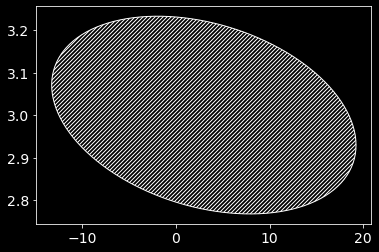

In [ ]:
plt.fill(x,y,fill=False,hatch='//////')

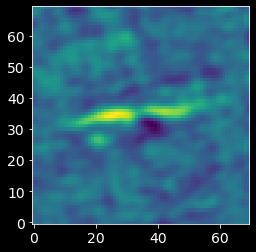

In [ ]:
plt.imshow(resid_m0_data[0,0,:,:], origin='lower')

In [ ]:
wcs_resid.shape

AttributeError: 'WCS' object has no attribute 'shape'